In [1]:
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import scipy as sp
import time

In [2]:
#opens .dat files to be converted into CSVs
#change pathprefix on different computers
EOS_files = "/home/tplohr/proj/SF 24-25/diettim NMMA master EOS-chiralEFT_MTOV/"
NICER_data = "/home/tplohr/proj/SF 24-25/data/J0030_Amsterdam_2019.dat"

def loadfile(number):
    file = open(EOS_files + str(number) + '.dat', 'r')
    return file

In [3]:
#creates an empty array to contain all EOSs 
numofEOS = 5000
EOSs = [None] * numofEOS

#fills "EOSs" with arrays of each EOS's mass and radius values 
for i in range(numofEOS):
    df = pd.read_csv(loadfile(i+1), delimiter = '\t', names = ["radius", "mass", "deformability"])
    EOSs[i] = np.array([df["radius"], df["mass"]])
#EOSs[i] is EOS_i
#EOSs[i][0] is the list of radius values of EOS_i
#EOSs[i][1] is the list of mass values of EOS_i
#EOSs[i][0][j] is the radius value indexed j of EOS_i
#EOSs[i][1][j] is the mass value indexed j of EOS_i

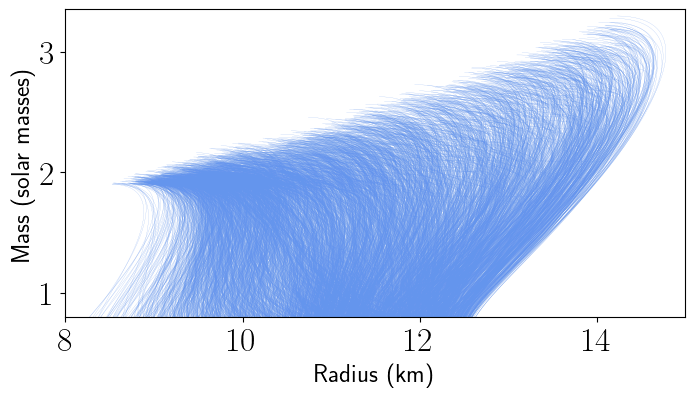

In [4]:
#plots each EOS 
plt.rcParams['figure.figsize'] = [8,4]
for i in range(numofEOS):
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.xlabel("Radius (km)", fontsize=18)
    plt.ylabel("Mass (solar masses)", fontsize=18)
    plt.plot(EOSs[i][0], EOSs[i][1], 'cornflowerblue', linewidth=.1)

In [5]:
#initialization of probability arrays

#probabilities of the EOSs given the observations, each index corresponds to one EOS; posterior
P_EOS_given_obs = np.zeros(numofEOS)
#probabilities of the observations given an EOS; likelihood
P_obs_given_EOS = np.zeros(numofEOS)
#probabilities of the EOSs without a condition; prior
P_EOS = np.ones(numofEOS)/numofEOS
#list of radius values each EOS predicts at M=1.4
r_at_given_mass = np.zeros(numofEOS)

In [6]:
mu_1 = 2.14
mu_2 = 2.01
mu_3 = 1.908
mu_4 = 2.16
sigma_1 = 0.1
sigma_2 = 0.04
sigma_3 = 0.016
sigma_4 = 0.17
#pdf of all CDFs combined
def pdf_1_evaluate(max_m):
    return sp.stats.norm.cdf(max_m, mu_1, sigma_1) * sp.stats.norm.cdf(max_m, mu_2, sigma_2) * sp.stats.norm.cdf(max_m, mu_3, sigma_3) * (1-sp.stats.norm.cdf(max_m, mu_4, sigma_4))

In [7]:
#reading in the data from NICER
dataframe = pd.read_csv(NICER_data, delim_whitespace=True, header=None)
selected_columns = dataframe.iloc[:,[1,2]]
data = selected_columns.to_numpy()[:10000]
print(np.shape(data))
#using a KDE to get the probability density function for the likelihood
pdf_2 = sp.stats.gaussian_kde((data[:,1], data[:,0]))
print(data[:,1])
print(data[:,0])

(10000, 2)
[11.66190213 12.92628253 12.9648249  ... 12.50780779 12.73977794
 12.33236365]
[1.2962671  1.09584669 1.29454128 ... 1.29311117 1.3139701  1.37314422]


In [8]:
#calculate the probability of the observations given an EOS; likelihood
num_points = 1000
def calc_P_obs_given_EOS(i):
    #r is the interpolated function r(m)
    r = sp.interpolate.interp1d(EOSs[i][1], EOSs[i][0])
    #radius at mass 1.4 
    r_at_given_mass[i] = r(1.4)
    
    #various radius values
    min_m = np.min(EOSs[i][1])
    max_m = np.max(EOSs[i][1])
    len_m = max_m-min_m
    #important to note that num_points is set, not delta_m
    delta_m = len_m/(num_points-1)
    #m is an array of all the mass values to sum over
    m = np.linspace(min_m, max_m, num_points)
    
    P = 0
    #loop over each mass value space by delta_m
    for j in range(num_points):
        #probability of EOS_i, using the NICER data, is the sum of the probability of each point multiplied by the distance to the next point
        P += pdf_2.evaluate((r(m[j]), m[j]))
    #then multiply by the probability using the max mass constraints
    P = P * pdf_1_evaluate(max_m) * delta_m
    return P

In [9]:
start=time.time()
norm_factor = 0
for i in range(numofEOS):
    #calculate the likelihood
    P_obs_given_EOS[i] = calc_P_obs_given_EOS(i)
    #calculate the denominator (sum of the numerator)
    norm_factor += P_obs_given_EOS[i]

#calculate the posterior
P_EOS_given_obs = P_obs_given_EOS / norm_factor
end=time.time()
print((end-start),'s', (end-start)/60, "m")

2561.242423772812 s 42.68737372954686 m


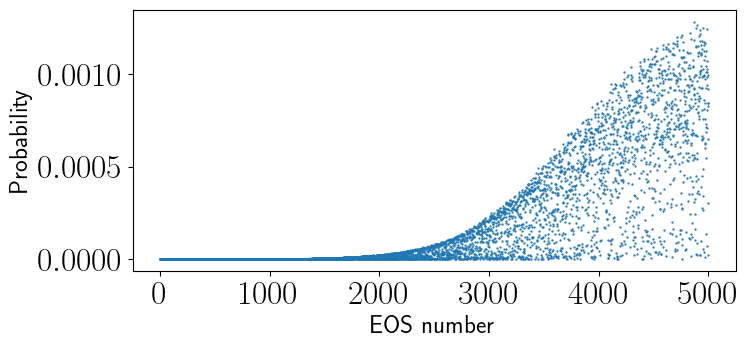

In [10]:
plt.xlabel("EOS number", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.scatter(np.linspace(0,numofEOS,5000), P_EOS_given_obs, s=0.4)
plt.tight_layout()
plt.savefig("/home/tplohr/proj/SF 24-25/figs/step_c/step_c_scatter_plot_loops.png")

In [11]:
tot_prob = 0
for i in range(numofEOS):
    tot_prob += P_EOS_given_obs[i]
print(tot_prob)

0.9999999999999987


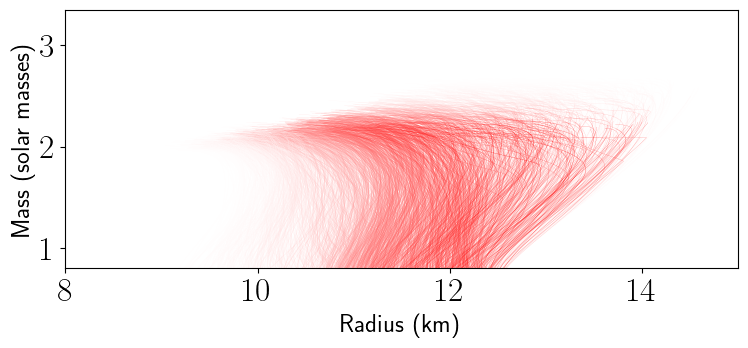

In [12]:
#plotting each EOS; low probability is white, high probability is red
cmap = mp.colors.LinearSegmentedColormap.from_list("white_to_red", ["white","red"])
norm = plt.Normalize(P_EOS_given_obs.min(), P_EOS_given_obs.max())
#plots each EOS 
plt.rcParams['figure.figsize'] = [8,4]
for i in range(numofEOS):
    color = cmap(norm(P_EOS_given_obs[i]))
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.xlabel("Radius (km)", fontsize=18)
    plt.ylabel("Mass (solar masses)", fontsize=18)
    plt.plot(EOSs[i][0], EOSs[i][1], color=color, linewidth=.1)
plt.tight_layout()
plt.savefig("/home/tplohr/proj/SF 24-25/figs/step_c/step_c_EOS_prob_loops.png")

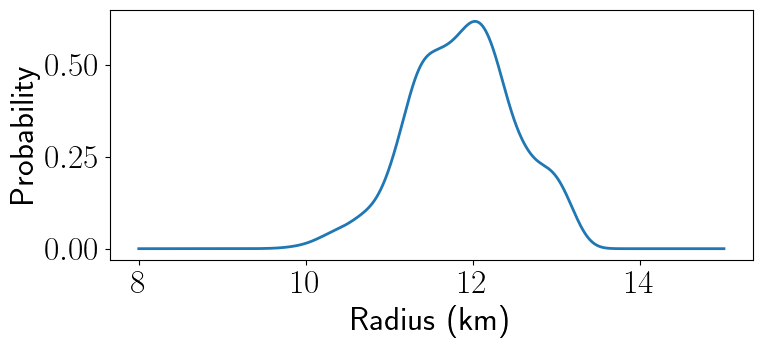

In [14]:
r_pdf = sp.stats.gaussian_kde((r_at_given_mass), weights=P_EOS_given_obs)
#plotting the radius pdf
Y = np.linspace(8, 15, 2000)
prob2=np.zeros(2000)
for i in range(2000):
    prob2[i] = r_pdf.evaluate(Y[i])
plt.xlabel("Radius (km)")
plt.ylabel("Probability")
plt.plot(Y, prob2)
plt.tight_layout()
plt.savefig("/home/tplohr/proj/SF 24-25/figs/step_c/step_c_r_PDF_loops.png")